/Users/sanjeev/personal/IITB-src/dl-project-delta3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



ENVIRONMENT DETECTION
 PyTorch Version: 2.9.0
 MPS Available: True
 CUDA Available: False
 Kaggle Environment: False
 Using Device: Apple Metal Performance Shaders (MPS)

CONFIGURATION
 Model: google/flan-t5-small
 Task: summarization
 Dataset Size: 100 (auto-reduced on Mac)

 Loading tokenizer...
 Tokenizer loaded

 Loading summarization dataset...
 Dataset loaded. Splits: ['train', 'validation', 'test']

 Subsampling dataset (size=100)...
 train: 100 samples
 validation: 50 samples
 test: 50 samples

 Tokenizing datasets...
 Datasets tokenized

 Loading model google/flan-t5-small...
 Loading on CPU first, then moving to MPS...
 Model moved to MPS
 Model loaded

 Configuring LoRA...
trainable params: 172,032 || all params: 77,133,184 || trainable%: 0.2230
 LoRA configured

 Configuring training arguments...
 Training arguments configured

 Initializing Trainer...
 Trainer initialized

STARTING TRAINING
 GPU Device: Apple MPS (auto-managed memory)



Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,1.913200,1.616857,0.394400,0.183000,0.325600
2,1.847600,1.614911,0.391400,0.181300,0.326100



 Training completed successfully!

PLOTTING METRICS


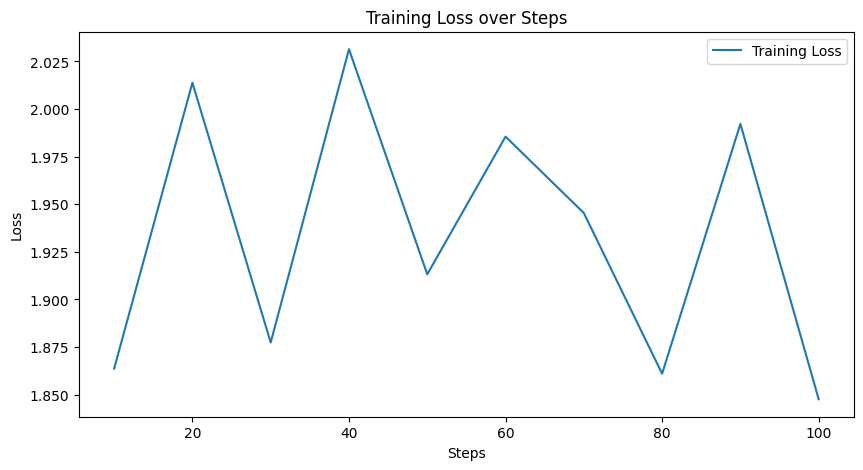

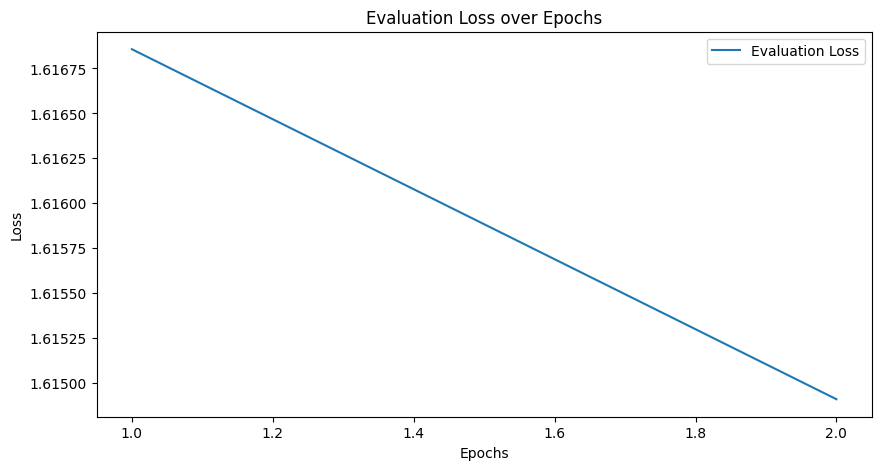

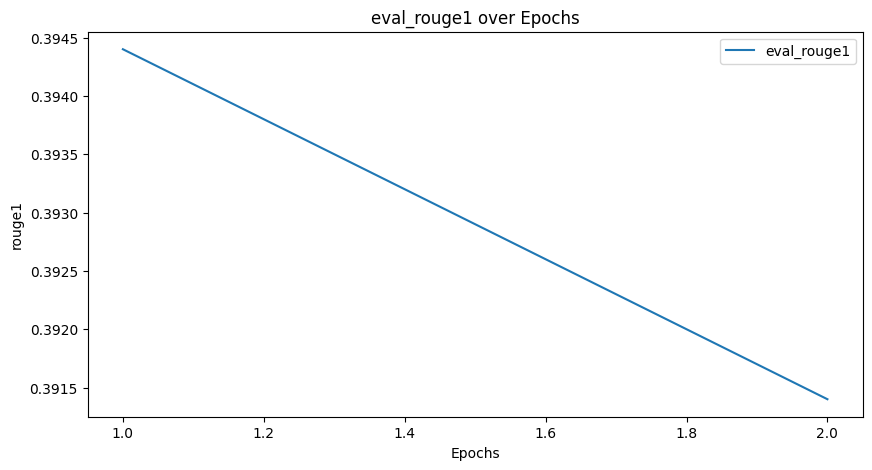

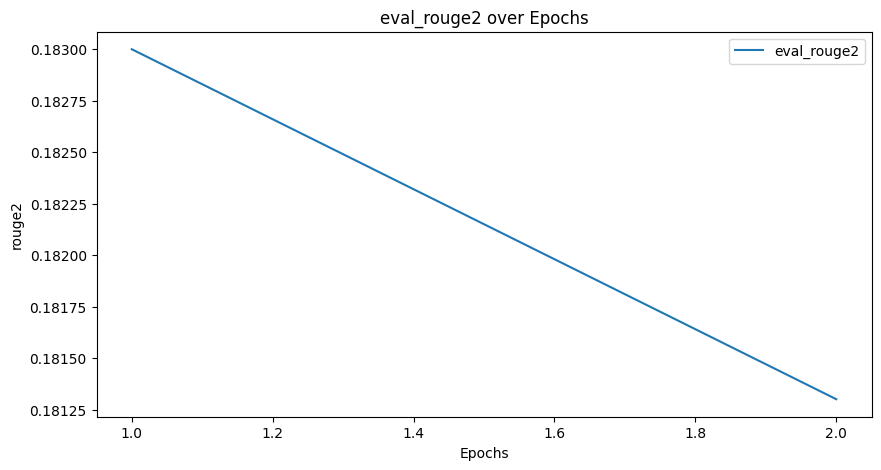

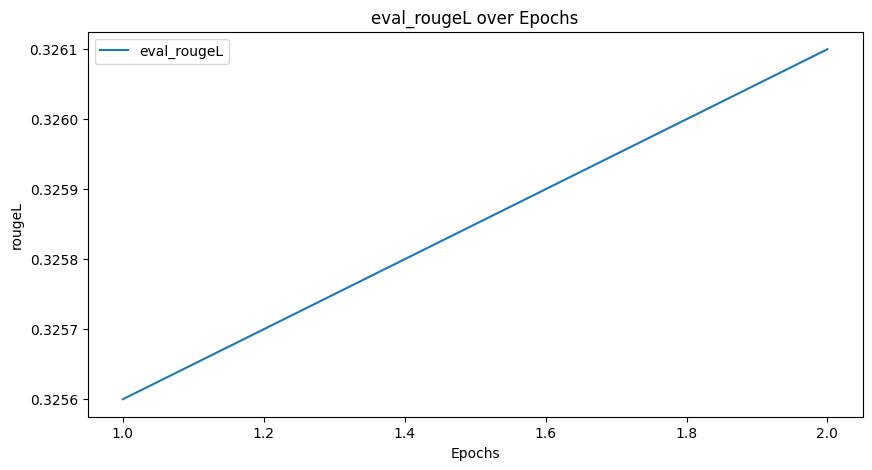


EVALUATING



 Test Results:
 eval_loss: 1.6223158836364746
 eval_rouge1: 0.4155
 eval_rouge2: 0.1578
 eval_rougeL: 0.3212
 eval_runtime: 39.3248
 eval_samples_per_second: 1.271
 eval_steps_per_second: 1.271
 epoch: 2.0

 Saving model and metrics...
 Model saved to ./summarization_flan_t5_small_lora_100_mac
 Metrics saved to summarization_metrics_100_mac.json

TRAINING SUMMARY
 Platform: Mac (MPS)
 Task: summarization
 Model: google/flan-t5-small
 Dataset Size: 100
 Training Epochs: 2
 Gradient Accumulation: 2
 LoRA Rank: 4
 Test Results: {'eval_loss': 1.6223158836364746, 'eval_rouge1': 0.4155, 'eval_rouge2': 0.1578, 'eval_rougeL': 0.3212, 'eval_runtime': 39.3248, 'eval_samples_per_second': 1.271, 'eval_steps_per_second': 1.271, 'epoch': 2.0}
 Model Directory: ./summarization_flan_t5_small_lora_100_mac
 Metrics File: summarization_metrics_100_mac.json
 GPU Device: Apple MPS (auto-managed memory)

 Training Complete!



In [ ]:
# ============================================================================
# LoRA FT - Summarization
# ============================================================================
# INSTALL DEPENDENCIES
# ============================================================================
import os
import sys
# Install required packages if running in Kaggle
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is not None:
    # Install evaluate and downgrade protobuf to fix compatibility issues
    os.system("pip install -q evaluate protobuf==3.20.3")
# else:
#     os.system("pip install -r /home/requirements.txt")

import gc
import json
import warnings
import numpy as np
import torch
from datasets import load_dataset
from peft import LoraConfig, TaskType, get_peft_model
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ============================================================================
# UNIVERSAL ENVIRONMENT DETECTION
# ============================================================================
print("\n" + "=" * 80)
print("ENVIRONMENT DETECTION")
print("=" * 80)

IS_MAC = torch.backends.mps.is_available()
IS_CUDA = torch.cuda.is_available()
IS_KAGGLE = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", None) is not None
if IS_MAC:
    DEVICE = "mps"
    DEVICE_NAME = "Apple Metal Performance Shaders (MPS)"
elif IS_CUDA:
    DEVICE = "cuda"
    DEVICE_NAME = f"CUDA - {torch.cuda.get_device_name(0)}"
else:
    DEVICE = "cpu"
    DEVICE_NAME = "CPU Only"

print(f" PyTorch Version: {torch.__version__}")
print(f" MPS Available: {IS_MAC}")
print(f" CUDA Available: {IS_CUDA}")
print(f" Kaggle Environment: {IS_KAGGLE}")
print(f" Using Device: {DEVICE_NAME}")

# ============================================================================
# ENVIRONMENT CONFIGURATION
# ============================================================================
# if IS_CUDA and not IS_MAC:
    # os.environ["WANDB_DISABLED"] = "true"
    # os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
# ============================================================================
# UNIVERSAL MEMORY MANAGEMENT
# ============================================================================
# def clear_gpu_memory():
#     if IS_MAC and torch.backends.mps.is_available():
#         torch.mps.empty_cache()
#     elif IS_CUDA and torch.cuda.is_available():
#         torch.cuda.empty_cache()
#     gc.collect()
# def get_gpu_memory_usage():
#     if IS_MAC:
#         return 0.0
#     if IS_CUDA:
#         return float(torch.cuda.memory_allocated() / 1024**3)
#     return 0.0
# def print_gpu_status():
#     if IS_MAC:
#         print(" GPU Device: Apple MPS (auto-managed memory)")
#     elif IS_CUDA:
#         total = torch.cuda.get_device_properties(0).total_memory / 1024**3
#         used = get_gpu_memory_usage()
#         print(f" GPU Memory Used: {used:.2f} GB / {total:.2f} GB")
#         print(f" GPU Device: {torch.cuda.get_device_name(0)}")
#     else:
#         print(" Using CPU - no GPU available")
# ============================================================================
# CONFIGURATION
# ============================================================================
model_name = "google/flan-t5-small"
task = "summarization" # or "classification"
dataset_size = 100 if IS_MAC else 'full'  # Use smaller dataset on Mac for memory constraintss
print("\n" + "=" * 80)
print("CONFIGURATION")
print("=" * 80)
print(f" Model: {model_name}")
print(f" Task: {task}")
print(f" Dataset Size: {dataset_size}")
# ============================================================================
# LOAD TOKENIZER
# ============================================================================
print("\n Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(" Tokenizer loaded")
# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================
def preprocess_summarization(examples):
    inputs = [f"summarize: {text}" for text in examples["text"]]
    model_inputs = tokenizer(
        inputs, max_length=512, truncation=True, padding=False
    )
    labels = tokenizer(
        examples["summary"], max_length=128, truncation=True, padding=False
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
def preprocess_classification(examples):
    label_map = {0: "negative", 1: "positive"}
    inputs = [
        f"classify sentiment: {text}" for text in examples["text"]
    ]
    model_inputs = tokenizer(
        inputs, max_length=512, truncation=True, padding=False
    )
    labels = tokenizer(
        [label_map[label] for label in examples["label"]],
        max_length=8,
        truncation=True,
        padding=False,
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# ============================================================================
# LOAD AND PREPARE DATASET
# ============================================================================
print(f"\n Loading {task} dataset...")
# clear_gpu_memory()
import evaluate
try:
    if task == "summarization":
        # Use knkarthick/samsum for summarization
        dataset = load_dataset("knkarthick/samsum")
        # Rename 'val' to 'validation' if necessary
        if "val" in dataset:
            dataset["validation"] = dataset.pop("val")
        dataset = dataset.rename_column("dialogue", "text")
        preprocess_function = preprocess_summarization
        metric = evaluate.load("rouge")
        splits = ["train", "validation", "test"]

    elif task == "classification":
        # Use imdb for sentiment classification
        dataset = load_dataset("imdb")
        # IMDB already has 'text' and 'label' columns, no need to rename
        # Remove 'unsupervised' split (has label=-1, unlabeled data)
        if "unsupervised" in dataset:
            del dataset["unsupervised"]
        # Split train into train/validation since IMDB only has train/test
        train_val = dataset["train"].train_test_split(test_size=0.1, seed=42)
        dataset["train"] = train_val["train"]
        dataset["validation"] = train_val["test"]
        preprocess_function = preprocess_classification
        metric = evaluate.load("accuracy")
        splits = ["train", "validation", "test"]

    else:
        raise ValueError("Task must be 'summarization' or 'classification'")
    print(f" Dataset loaded. Splits: {list(dataset.keys())}")
except Exception as e:
    print(f" Error loading dataset: {e}")
    print(" Please check your internet connection")
    raise SystemExit(1)

# ============================================================================
# SUBSAMPLE DATASET
# ============================================================================
print(f"\n Subsampling dataset (size={dataset_size})...")
if dataset_size != "full":
    for split in splits:
        if split in dataset:
            available = len(dataset[split])
            num_samples = min(
                dataset_size if split == "train" else max(50, dataset_size // 2),
                available,
            )
            dataset[split] = dataset[split].shuffle(seed=42).select(
                range(num_samples)
            )
            print(f" {split}: {num_samples} samples")

# ============================================================================
# TOKENIZE DATASETS
# ============================================================================
print("\n Tokenizing datasets...")
# clear_gpu_memory()
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing",
)
print(" Datasets tokenized")

# ============================================================================
# LOAD MODEL
# ============================================================================
print(f"\n Loading model {model_name}...")
# clear_gpu_memory()
try:
    if IS_MAC:
        print(" Loading on CPU first, then moving to MPS...")
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name,
            device_map="cpu",
            low_cpu_mem_usage=True,
        )
        base_model = base_model.to("mps")
        print(" Model moved to MPS")
    else:
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name,
            device_map="auto" if IS_CUDA else "cpu",
            low_cpu_mem_usage=True,
        )
    print(" Model loaded")
except Exception as e:
    print(f" Error loading model: {e}")
    raise SystemExit(1)

# ============================================================================
# CONFIGURE LORA
# ============================================================================
print("\n Configuring LoRA...")
lora_r = 4 if IS_MAC else 32
lora_alpha = 8 if IS_MAC else 32
lora_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()
print(" LoRA configured")
# ============================================================================
# DATA COLLATOR
# ============================================================================
data_collator = DataCollatorForSeq2Seq(
    tokenizer, model=model, padding=True
)
# ============================================================================
# METRICS COMPUTATION
# ============================================================================
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    # Replace -100 with pad_token_id (ignore_index)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    try:
        decoded_preds = tokenizer.batch_decode(
            predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
    except OverflowError:
        # Clip predictions to valid token IDs range if overflow error occurs
        max_id = tokenizer.vocab_size - 1
        predictions = np.clip(predictions, 0, max_id)
        decoded_preds = tokenizer.batch_decode(
            predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
    decoded_labels = tokenizer.batch_decode(
        labels, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    if task == "summarization":
        try:
            result = metric.compute(
                predictions=decoded_preds, references=decoded_labels, use_stemmer=True
            )
            return {
                "rouge1": round(result["rouge1"], 4),
                "rouge2": round(result["rouge2"], 4),
                "rougeL": round(result["rougeL"], 4),
            }
        except Exception as e:
            print(f" Error computing ROUGE: {e}")
            return {"rouge1": 0.0}
    else:
        preds = [p.strip() for p in decoded_preds]
        refs = [r.strip() for r in decoded_labels]
        # Update label map for IMDB
        label_map_rev = {"negative": 0, "positive": 1}
        pred_ids = [label_map_rev.get(p, -1) for p in preds]
        ref_ids = [label_map_rev.get(r, -1) for r in refs]
        pairs = [(p, r) for p, r in zip(pred_ids, ref_ids) if p != -1 and r != -1]
        if not pairs:
            return {"accuracy": 0.0}
        pred_ids, ref_ids = zip(*pairs)
        result = metric.compute(predictions=pred_ids, references=ref_ids)
        return result
# ============================================================================
# TRAINING ARGUMENTS (SAFE FOR PEFT/LORA)
# ============================================================================
print("\n Configuring training arguments...")
num_epochs = 2 if IS_MAC else 5
grad_accum = 2 if IS_MAC else 4
fp16_enabled = IS_CUDA and not IS_MAC
use_8bit_optimizer = False # keep adamw_torch for stability
training_args = Seq2SeqTrainingArguments(
    output_dir=f"./{task}_flan_t5_small_lora_{dataset_size}_{'mac' if IS_MAC else 'gpu'}",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=grad_accum,
    warmup_steps=50,
    weight_decay=0.0, # safer for LoRA-only training
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=fp16_enabled,
    bf16=False,
    report_to="none",
    gradient_checkpointing=False, # avoid known PEFT issues
    optim="adamw_torch",
    learning_rate=1e-4,
    seed=42,
    dataloader_pin_memory=not IS_MAC,
    dataloader_num_workers=0,
    remove_unused_columns=False,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=1,
)
print(" Training arguments configured")
# ============================================================================
# CREATE TRAINER
# ============================================================================
print("\n Initializing Trainer...")
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets.get(
        "validation", tokenized_datasets["train"]
    ),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
print(" Trainer initialized")
# ============================================================================
# TRAINING
# ============================================================================
print("\n" + "=" * 80)
print("STARTING TRAINING")
print("=" * 80)
print_gpu_status()
print()
clear_gpu_memory()
try:
    model.train() # ensure LoRA params require grad
    trainer.train()
    print("\n Training completed successfully!")
except KeyboardInterrupt:
    print("\n Training interrupted by user")
except RuntimeError as e:
    if "does not require grad" in str(e):
        print(
            "\n RuntimeError: some tensors do not require grad.\n"
            " Check that LoRA parameters are trainable and gradient_checkpointing is False."
        )
    if "out of memory" in str(e).lower():
        print("\n Out of memory error.")
        print(" Try reducing dataset_size or lowering lora_r.")
    raise
# ============================================================================
# PLOTTING METRICS
# ============================================================================
print("\n" + "=" * 80)
print("PLOTTING METRICS")
print("=" * 80)
log_history = trainer.state.log_history
# Extract data
steps = []
train_losses = []
epochs = []
eval_losses = []
eval_metrics = {}  # for different metrics
for log in log_history:
    if 'loss' in log:
        steps.append(log['step'])
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        epochs.append(log['epoch'])
        eval_losses.append(log['eval_loss'])
        # Add other metrics
        for k in log:
            if k.startswith('eval_') and k != 'eval_loss' and k != 'eval_runtime' and k != 'eval_samples_per_second' and k != 'eval_steps_per_second':
                if k not in eval_metrics:
                    eval_metrics[k] = []
                eval_metrics[k].append(log[k])
# Plot training loss
if train_losses:
    plt.figure(figsize=(10,5))
    plt.plot(steps, train_losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss over Steps')
    plt.legend()
    plt.savefig('training_loss.png')
    plt.show()
    plt.close()
# Plot eval loss
if eval_losses:
    plt.figure(figsize=(10,5))
    plt.plot(epochs, eval_losses, label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Evaluation Loss over Epochs')
    plt.legend()
    plt.savefig('eval_loss.png')
    plt.show()
    plt.close()
# Plot eval metrics
for metric_name, values in eval_metrics.items():
    plt.figure(figsize=(10,5))
    plt.plot(epochs, values, label=metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.split('eval_')[1])
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.savefig(f'{metric_name}.png')
    plt.show()
    plt.close()
# ============================================================================
# EVALUATION
# ============================================================================
print("\n" + "=" * 80)
print("EVALUATING")
print("=" * 80)
clear_gpu_memory()
try:
    test_results = trainer.evaluate(
        tokenized_datasets.get("test", tokenized_datasets["validation"])
    )
    print("\n Test Results:")
    for k, v in test_results.items():
        print(f" {k}: {v}")
except Exception as e:
    print(f"\n Evaluation error: {e}")
    test_results = {}
# ============================================================================
# SAVE RESULTS
# ============================================================================
print("\n Saving model and metrics...")
model_dir = f"./{task}_flan_t5_small_lora_{dataset_size}_{'mac' if IS_MAC else 'gpu'}"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)
metrics_file = (
    f"{task}_metrics_{dataset_size}_{'mac' if IS_MAC else 'gpu'}.json"
)
metrics_dict = {
    "model": model_name,
    "task": task,
    "platform": "Mac (MPS)"
    if IS_MAC
    else "GPU (CUDA)"
    if IS_CUDA
    else "CPU",
    "dataset_size": dataset_size,
    "test_results": test_results,
    "training_config": {
        "epochs": training_args.num_train_epochs,
        "batch_size": training_args.per_device_train_batch_size,
        "gradient_accumulation": training_args.gradient_accumulation_steps,
        "lora_r": lora_r,
        "lora_alpha": lora_alpha,
        "fp16": fp16_enabled,
        "optimizer": training_args.optim,
    },
}
with open(metrics_file, "w") as f:
    json.dump(metrics_dict, f, indent=4)
print(f" Model saved to {model_dir}")
print(f" Metrics saved to {metrics_file}")
# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING SUMMARY")
print("=" * 80)
print(f" Platform: {'Mac (MPS)' if IS_MAC else 'GPU (CUDA)' if IS_CUDA else 'CPU'}")
print(f" Task: {task}")
print(f" Model: {model_name}")
print(f" Dataset Size: {dataset_size}")
print(f" Training Epochs: {training_args.num_train_epochs}")
print(f" Gradient Accumulation: {training_args.gradient_accumulation_steps}")
print(f" LoRA Rank: {lora_r}")
print(f" Test Results: {test_results}")
print(f" Model Directory: {model_dir}")
print(f" Metrics File: {metrics_file}")
print_gpu_status()
print("=" * 80)
print("\n Training Complete!\n")